In [1]:
import numpy as np
import matplotlib.pyplot as plt

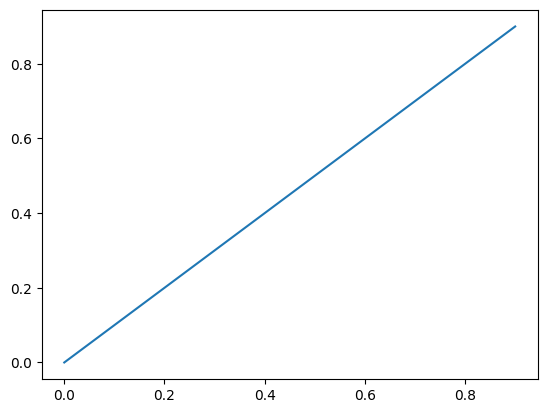

In [2]:
plt.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1))

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import torch.nn.functional as F

In [4]:
from scipy import stats
import time

from sklearn.metrics import auc

In [12]:
os.chdir('D:\OneDrive - HKUST Connect\Research\GWNMMAD\GWAD\Codes')

In [5]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

## Testing Andy's framework

### the network

In [6]:
class WaveNet(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024, 
        l2: int=128,
        lx: int=200
    ):
        
        super(WaveNet, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=2
            )
        
        self.Conv_Out = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.body_norm = nn.GroupNorm(4 ,n_chann)
        self.end_norm = nn.BatchNorm1d(1)
        
        self.WaveNet_layers = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers.append(conv_layer)
        
        
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
        
        self.L1_norm = nn.BatchNorm1d(200-2**c_depth)
        self.L1 = nn.Linear(200-2**c_depth, l1)
        self.L2_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, l2)
        self.L3_norm = nn.BatchNorm1d(l2)
        self.L3 = nn.Linear(l2, 1)


        nn.init.kaiming_normal_(self.Conv_In.weight)
        nn.init.kaiming_normal_(self.Conv_Out.weight)
        nn.init.constant_(self.Conv_In.bias, 0.001)
        nn.init.constant_(self.Conv_Out.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def forward(self, x):

        x = self.cap_norm(x)
        x = self.Conv_In(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers:
            x = self.body_norm(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out(x)
        x = F.relu(x)
        x = self.end_norm(x)
        
        x = torch.flatten(x, 1)
        
        
        x = F.relu(self.L1(x))
        x = self.L2_norm(x)
        x = F.relu(self.L2(x))
        x = self.L3_norm(x)
        # x = F.softmax(self.L3(x), dim = 1)
        x = self.L3(x)
        
        return x

In [7]:
andyAE = WaveNet(num_ifos=1, c_depth=5, n_chann=8, l1=64, l2=16, lx=200).cuda()
print(sum(p.numel() for p in andyAE.parameters() if p.requires_grad))

13102


In [8]:
def upperTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        threshold = np.sort(trainerror)[-index_number]
            
        # print(threshold)
        # print(np.argwhere(signalerror >= threshold).shape)
        TPRlist[i] = np.argwhere(signalerror > threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

def lowerTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        if index_number == 0:
            threshold = np.sort(trainerror)[index_number]
        else:
            threshold = np.sort(trainerror)[index_number-1]
        # print(np.sort(trainerror))
        # print(threshold)
        # print(np.argwhere(signalerror < threshold).shape)
        TPRlist[i] = np.argwhere(signalerror < threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

FPR_list = np.logspace(-3,0,100)

### data preparation

In [13]:
renorm_factor = 20;

realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

In [110]:
# A permutated one, here the BBH and SG got switched


renorm_factor = 20;

realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

In [118]:
# A permutated one, here the BBH and BKG got switched


renorm_factor = 20;

realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

In [14]:
realbkg_trimmed = realbkg[:, 0];
realbbh_trimmed = realbbh[:, 0];
realsg_trimmed  = realsg[:, 0];

realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)]);
realbbh_trimmed = (realbbh_trimmed - np.transpose([np.mean(realbbh_trimmed, axis=1)]))/np.transpose([np.std(realbbh_trimmed, axis=1)]);
realsg_trimmed  = (realsg_trimmed  - np.transpose([np.mean(realsg_trimmed , axis=1)]))/np.transpose([np.std(realsg_trimmed,  axis=1)]);

realglitch_trimmed = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

In [120]:
dInput = realbkg_trimmed.shape[1]

nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_ns = int(0.4*nTrain)
nTest_ns = int(0.4*nTest)
nValid_ns = int(0.4*nValid)

nTrain_g = int(0.2*nTrain)
nTest_g = int(0.2*nTest)
nValid_g = int(0.2*nValid)

X_train = np.empty((nTrain + 2*nTrain_ns + nTrain_g, dInput))
X_test  = np.empty((nTest + 2*nTest_ns + nTest_g,  dInput))
X_valid = np.empty((nValid + 2*nValid_ns + nValid_g, dInput))

target_train = np.zeros((nTrain + 2*nTrain_ns + nTrain_g, ), dtype="int64")
target_test  = np.zeros((nTest + 2*nTest_ns + nTest_g, ), dtype="int64")
target_valid = np.zeros((nValid + 2*nValid_ns + nValid_g, ), dtype="int64")

# permBKG = np.random.permutation(nTotal)
# permBBH = np.random.permutation(nTotal)
# permSG  = np.random.permutation(nTotal)
# permGLITCH = np.random.permutation(len(realglitch_trimmed))

# np.savetxt("../Data_cached/SupLearn/permAF_BKG_1.dat", permBKG)
# np.savetxt("../Data_cached/SupLearn/permAF_BBH_1.dat", permBBH)
# np.savetxt("../Data_cached/SupLearn/permAF_SG_1.dat", permSG)
# np.savetxt("../Data_cached/SupLearn/permAF_GLITCH_1.dat", permGLITCH)

permBKG = np.genfromtxt("../Data_cached/SupLearn/permAF_BKG_2.dat").astype(int)
permBBH = np.genfromtxt("../Data_cached/SupLearn/permAF_BBH_2.dat").astype(int)
permSG = np.genfromtxt("../Data_cached/SupLearn/permAF_SG_2.dat").astype(int)
permGLITCH = np.genfromtxt("../Data_cached/SupLearn/permAF_GLITCH_2.dat").astype(int)


# initializing the training set
X_train[ : nTrain] = realbbh_trimmed[permBBH[:nTrain]]
X_train[nTrain : nTrain+nTrain_ns] = realbkg_trimmed[permBKG[:nTrain_ns]]
X_train[nTrain+nTrain_ns : nTrain+2*nTrain_ns] = realsg_trimmed[permSG[:nTrain_ns]]
X_train[nTrain+2*nTrain_ns : ] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;
# target_train = 1-target_train

# initializing the test set
X_test[ : nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[nTest : nTest+nTest_ns] = realbkg_trimmed[permBKG[-nTest_ns:]]
X_test[nTest+nTest_ns : nTest+2*nTest_ns] = realsg_trimmed[permSG[-nTest_ns:]]
X_test[nTest+2*nTest_ns : ] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;

# initializing the validation set
X_valid[:nValid] = realbbh_trimmed[permBBH[nTrain : -nTest]]
X_valid[nValid : nValid+nValid_ns] = realbkg_trimmed[permBKG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+nValid_ns : nValid+2*nValid_ns] = realsg_trimmed[permSG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+2*nValid_ns : ] = realglitch_trimmed[permGLITCH[nTrain_g : nTrain_g+nValid_g]]

target_valid[:nValid] = 1;

train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(target_train.reshape((len(target_train), 1))))
test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test), 1))))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))), torch.FloatTensor(target_valid.reshape((len(target_valid), 1))))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

### training

In [25]:
train_dataset.tensors[0].shape

torch.Size([140000, 1, 200])

In [26]:
dInput

200

In [27]:
nn.BCEWithLogitsLoss()(torch.tensor([0.1]), torch.tensor([1.]))

tensor(0.6444)

In [28]:
nn.BCEWithLogitsLoss()(torch.tensor([[0.1], [0.2]]), torch.tensor([[1.], [0.]]))

tensor(0.7213)

In [29]:
nn.BCELoss()(torch.tensor([0.1, 0.2]), torch.tensor([1., 0.]))

tensor(1.2629)

In [30]:
nn.Sigmoid()(torch.tensor([[0.1], [0.2]]))

tensor([[0.5250],
        [0.5498]])

In [31]:
(-np.log(0.525)-np.log(1-0.5498))/2

0.7212101834500091

13102
Epoch: 0001, Training loss=0.612329, Validation loss=0.779178, valid accuracy=16.000000
11.690919876098633
Epoch: 0002, Training loss=0.581121, Validation loss=1.194929, valid accuracy=16.000000
11.53721570968628
Epoch: 0003, Training loss=0.586247, Validation loss=1.434655, valid accuracy=16.000000
11.562158584594727
Epoch: 0004, Training loss=0.725186, Validation loss=1.547123, valid accuracy=16.000000
11.456277132034302
Epoch: 0005, Training loss=0.294453, Validation loss=1.794704, valid accuracy=16.000000
11.441863298416138
Epoch: 0006, Training loss=0.243941, Validation loss=1.919646, valid accuracy=16.000000
11.451204299926758
Epoch: 0007, Training loss=0.405528, Validation loss=2.004808, valid accuracy=16.000000
11.383827686309814
Epoch: 0008, Training loss=0.379878, Validation loss=2.081932, valid accuracy=16.000000
11.413159132003784
Epoch: 0009, Training loss=0.328925, Validation loss=2.236364, valid accuracy=16.000000
11.507508993148804
Epoch: 0010, Training loss=0.482

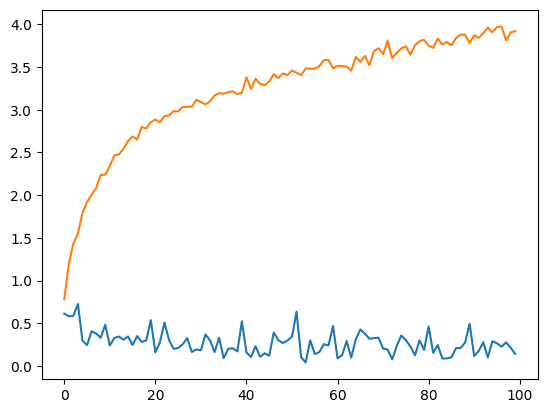

In [85]:
classifier = WaveNet(num_ifos=1, c_depth=5, n_chann=8, l1=64, l2=16, lx=dInput).cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/SupLearn/ClassifierAF_BKGtrained_reversed.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

In [39]:
classifier = torch.load('../Model_cached/SupLearn/ClassifierAF.pt')

In [100]:
classifier = torch.load('../Model_cached/SupLearn/ClassifierAF_BBHtrained.pt')

In [113]:
classifier = torch.load('../Model_cached/SupLearn/ClassifierAF_SGtrained.pt')

In [124]:
classifier = torch.load('../Model_cached/SupLearn/ClassifierAF_BKGtrained_reversed.pt')

In [101]:
classifier.cpu().eval();

In [102]:
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5

### Accuracy for BBH

In [103]:
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.94805

In [92]:
len(test_dataset)

40000

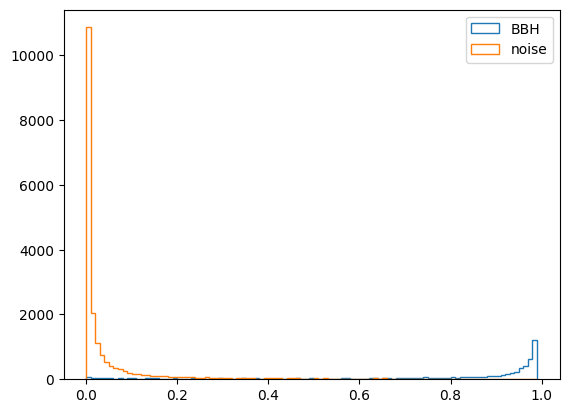

20000
20000


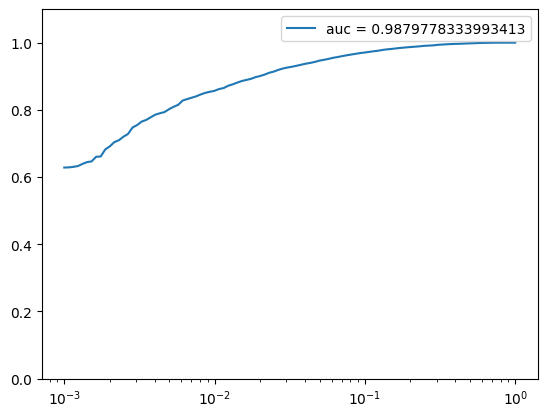

In [104]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'BBH')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

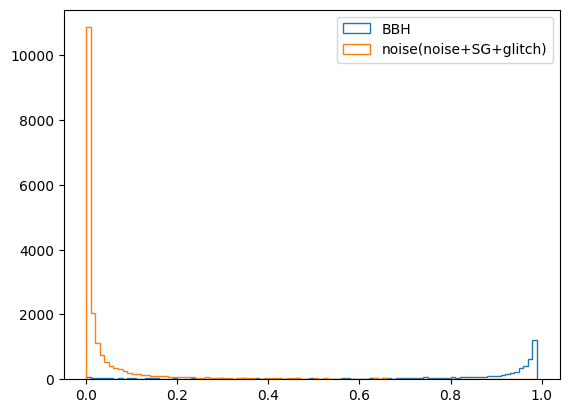

20000
20000


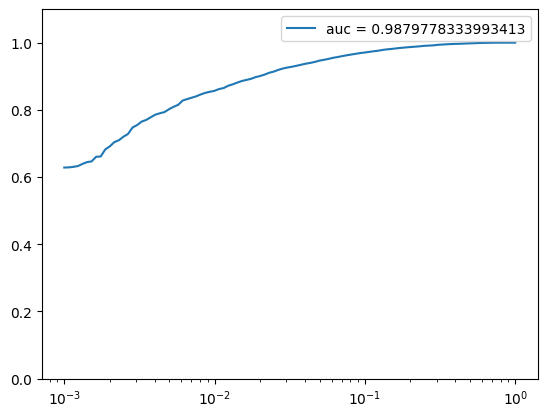

In [105]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'BBH')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise(noise+SG+glitch)')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [108]:
np.vstack((FPR_list, TPR_list)).T

(2, 100)

In [109]:
np.save('../Data_cached/ROC_BBH_AF.npy', np.vstack((FPR_list, TPR_list)).T)

### Accuracy for SG

In [20]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.918075

In [21]:
len(test_dataset)

40000

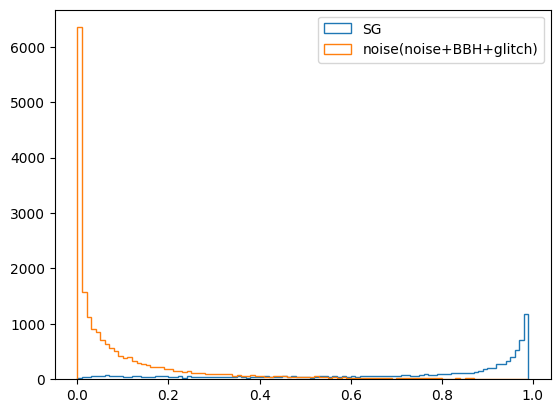

20000
20000


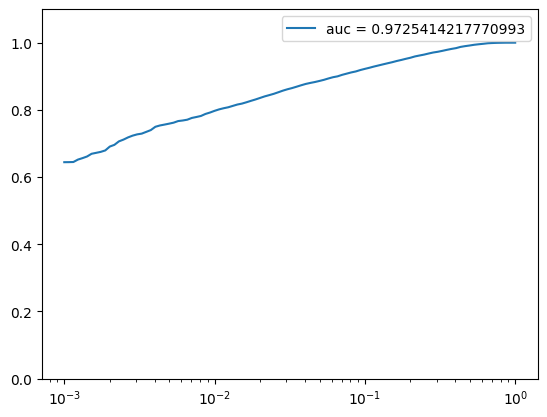

In [67]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'SG')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise(noise+BBH+glitch)')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

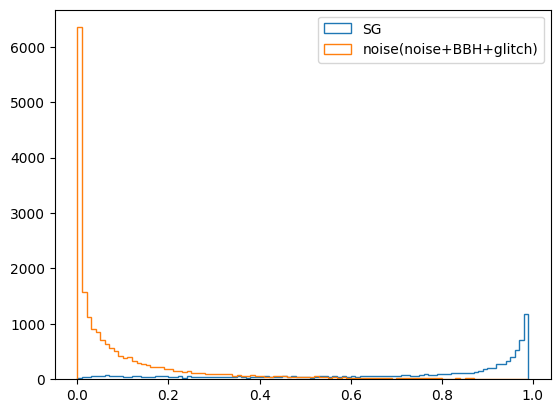

20000
20000


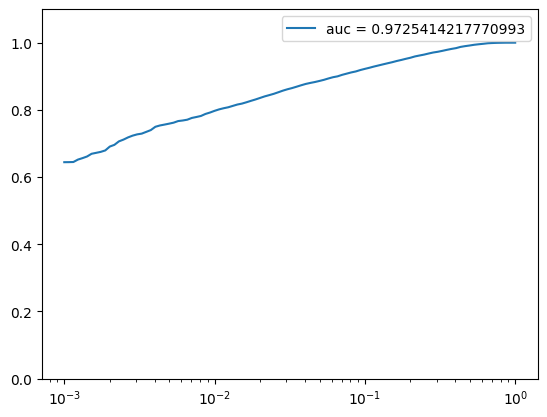

In [115]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'SG')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise(noise+BBH+glitch)')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [117]:
np.save('../Data_cached/ROC_SG_AF.npy', np.vstack((FPR_list, TPR_list)).T)

### Accuracy for noise

In [122]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.898

In [83]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.9186

In [74]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.898

In [34]:
len(test_dataset)

40000

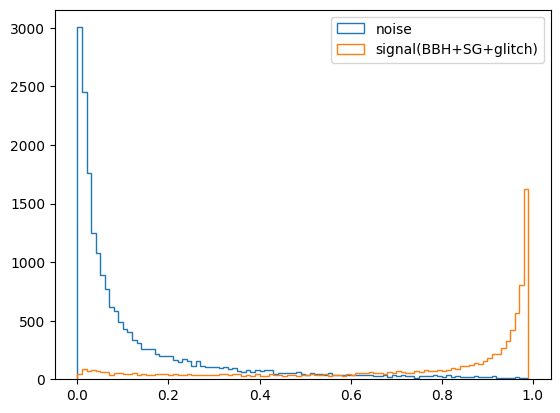

20000
20000


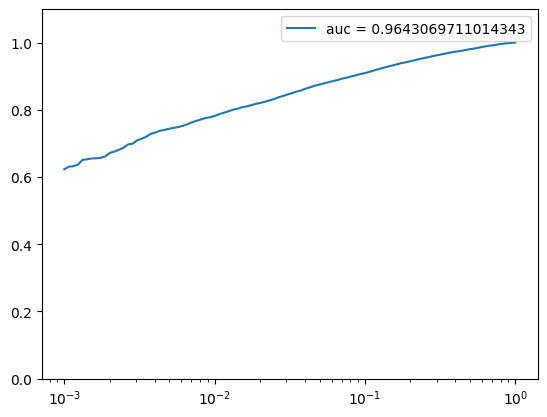

In [87]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'noise')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'signal(BBH+SG+glitch)')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[:nTest].flatten(), prediction[nTest:].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

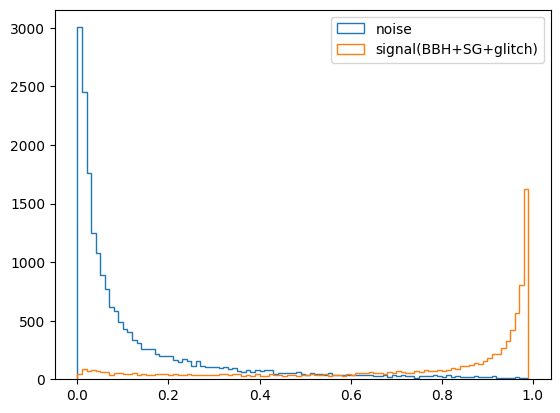

20000
20000


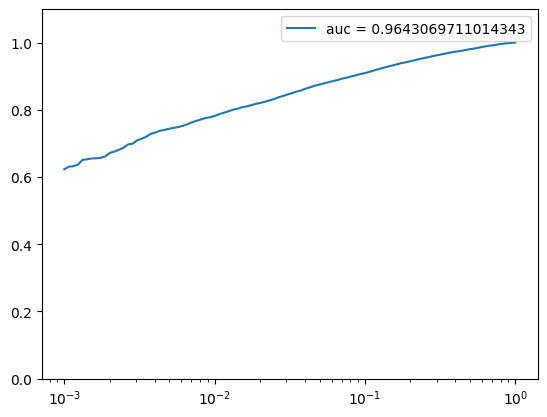

In [125]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'noise')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'signal(BBH+SG+glitch)')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[:nTest].flatten(), prediction[nTest:].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [126]:
np.save('../Data_cached/ROC_BKG_AF.npy', np.vstack((FPR_list, TPR_list)).T)

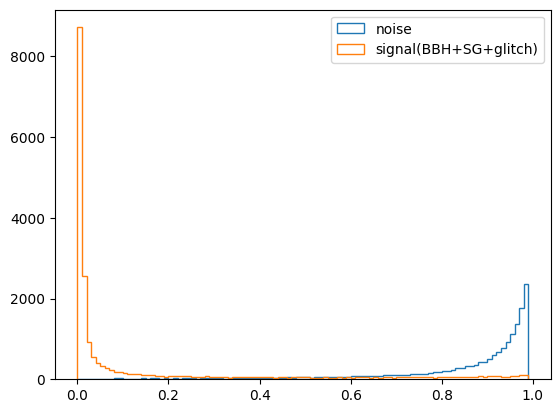

20000
20000


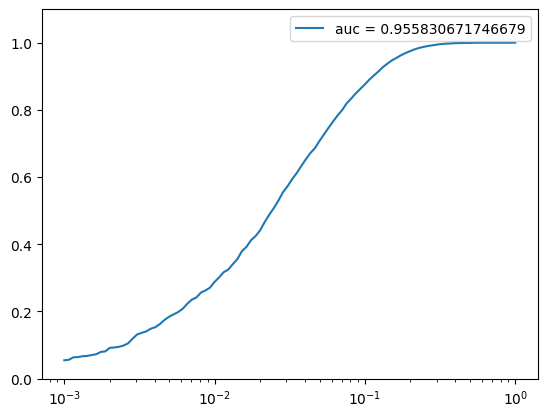

In [75]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'noise')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'signal(BBH+SG+glitch)')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

### For low SNR and inspiral phase

#### GWAK noise trained model

In [36]:
model = torch.load('../Model_cached/SupLearn/ClassifierAF_BKGtrained_reversed.pt').cpu()

In [37]:
realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:100000]
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:100000]

realbkg = np.hstack((realbkg_L[:100000], realbkg_H[:100000])).reshape(-1,200)


bkg = realbkg[:int(len(realbkg)*0.7)]
bkg_reserved = realbkg[int(len(realbkg)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = (bkg_reserved - np.transpose([np.mean(bkg_reserved, axis=1)]))/np.transpose([np.std(bkg_reserved, axis=1)])

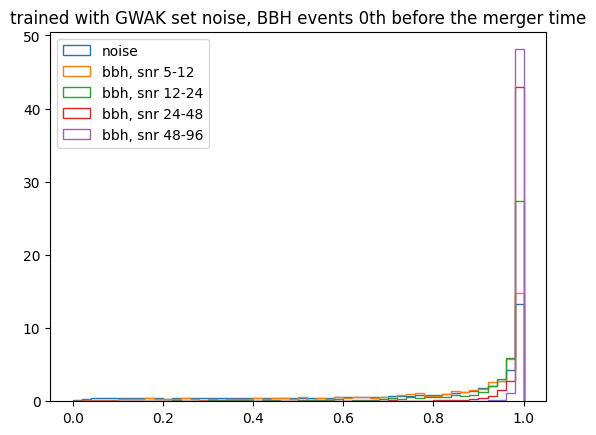

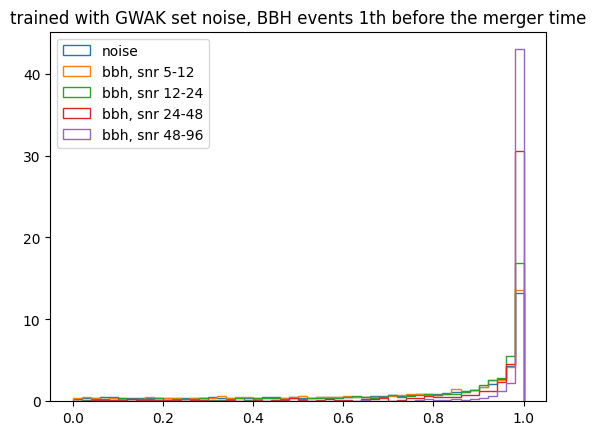

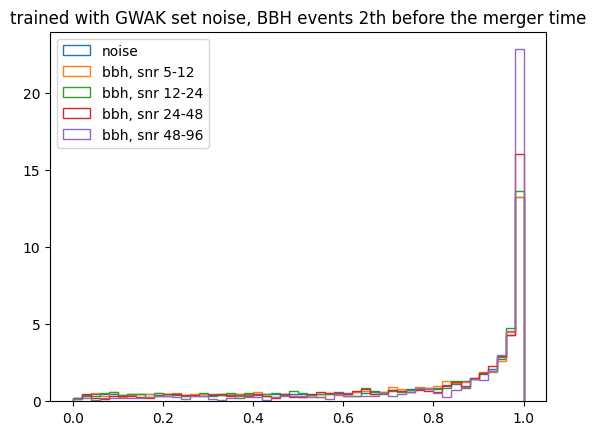

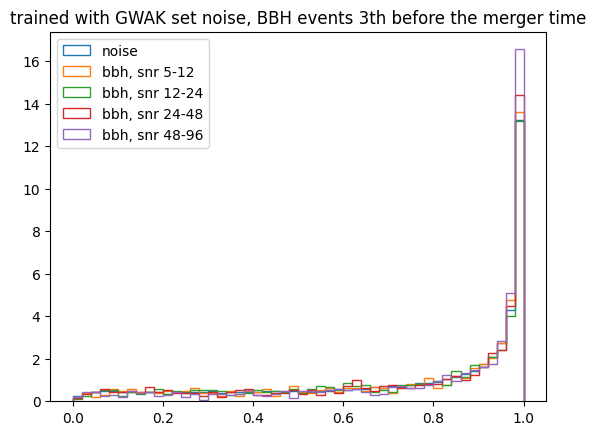

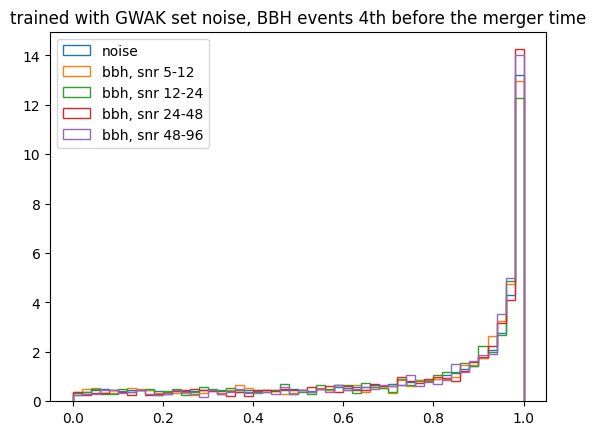

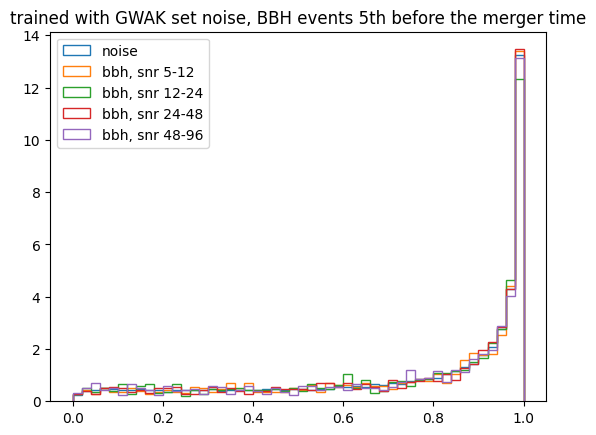

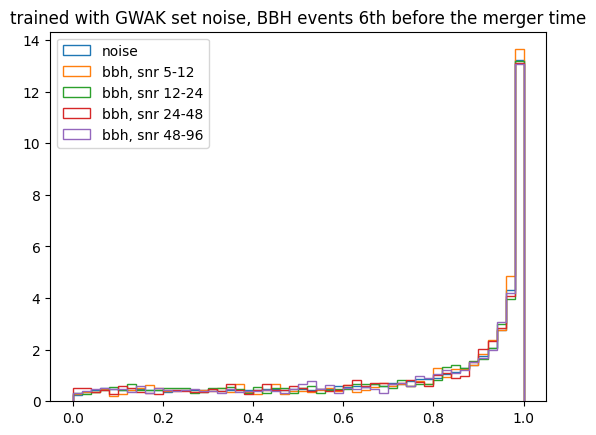

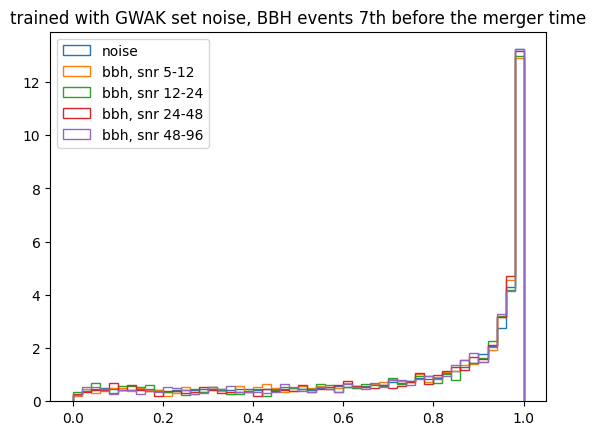

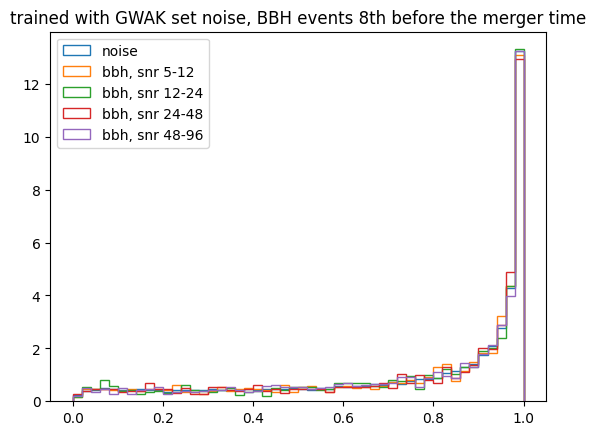

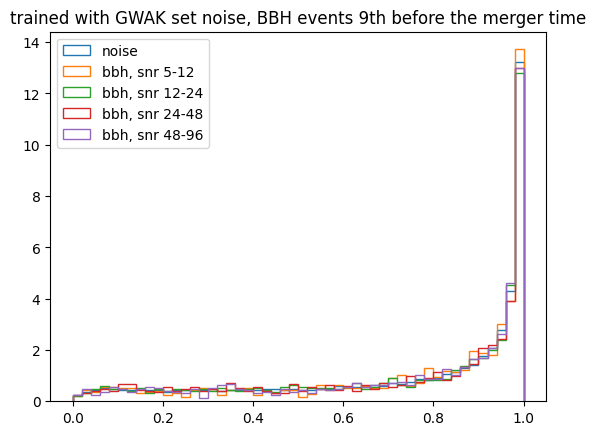

In [38]:
idx_list = np.arange(10)
snr_list = ['5-12','12-24','24-48','48-96']

realbbh_list = {}

for idx in idx_list:
    for snr_range in snr_list:
    
        realbbh_data = np.load('../Data_cached/injected_BBH_snr'+ snr_range +'_' + str(idx) + 'th_events_before_merger_time.npz')['strain'].reshape(-1,200)
        realbbh_data = (realbbh_data - np.transpose([np.mean(realbbh_data, axis=1)]))/np.transpose([np.std(realbbh_data, axis=1)])
        
        realbbh_data = realbbh_data.reshape(-1,400)
        
        realbbh_list[snr_range] = realbbh_data.reshape(-1,2,200)

    bkg_reserved = bkg_reserved.reshape(-1,2,200)

    dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_reserved[:,[0],:]))).detach().numpy()
    # dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
    # dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
    # dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in realbbh_list.keys():
        dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(realbbh_list[snr][:,[0],:]))).detach().numpy()
        foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh, snr " + snr)

    plt.title("trained with GWAK set noise, BBH events {}th before the merger time".format(idx))
    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    # plt.ylim(0,2000)
    plt.legend()
    plt.show()

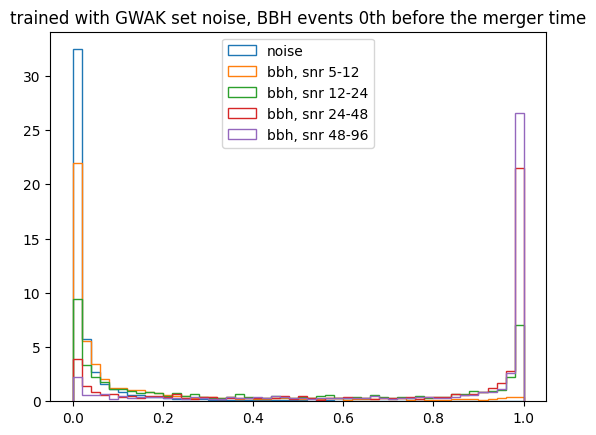

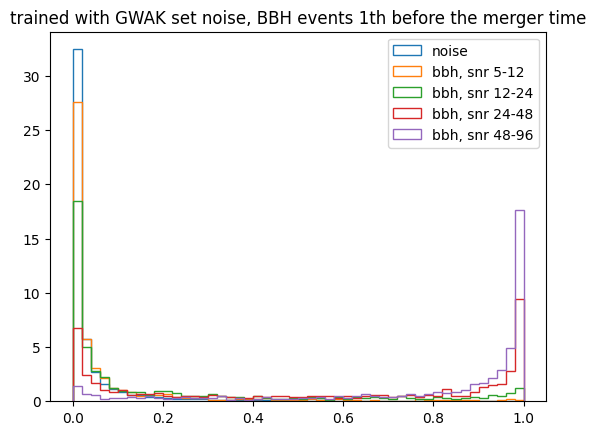

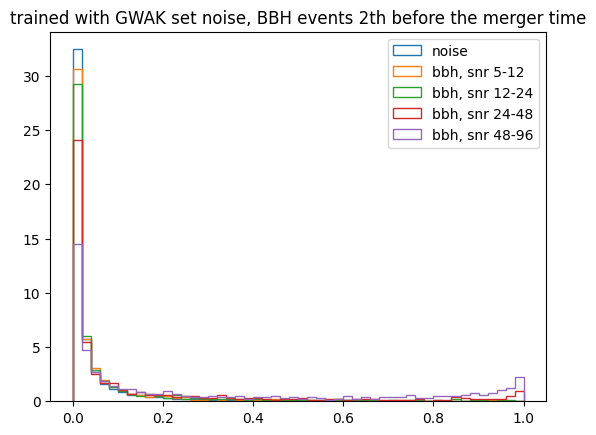

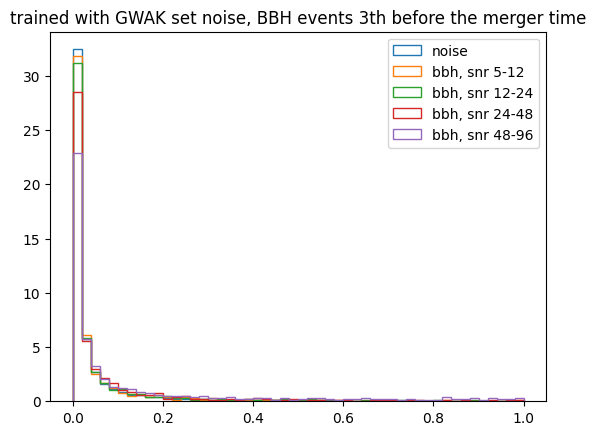

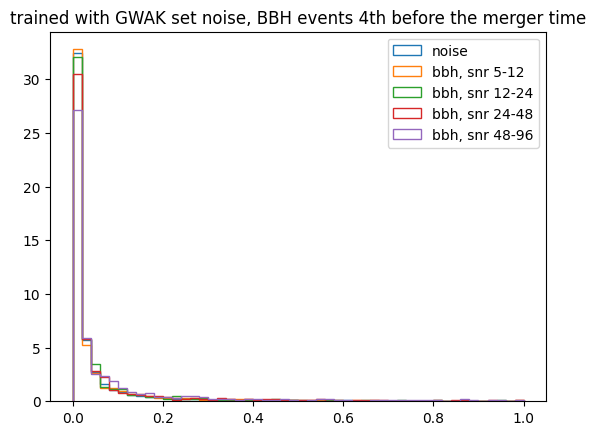

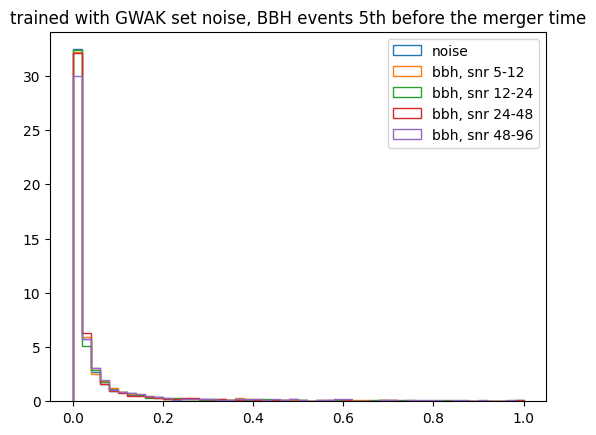

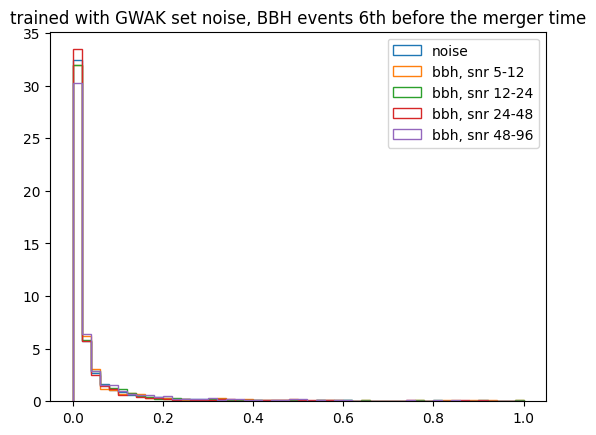

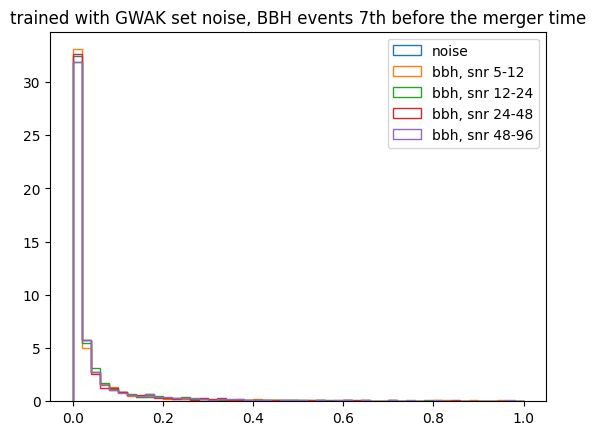

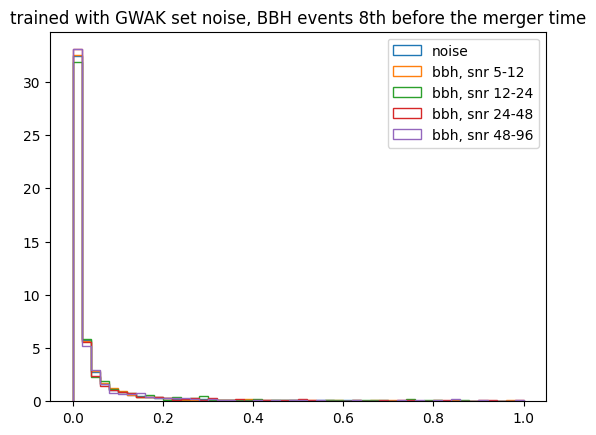

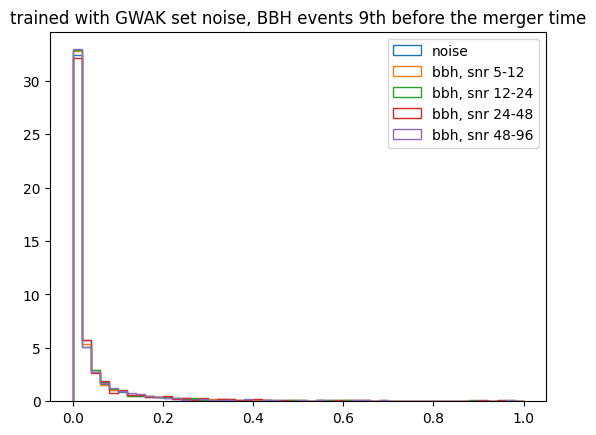

In [29]:
idx_list = np.arange(10)
snr_list = ['5-12','12-24','24-48','48-96']

realbbh_list = {}

for idx in idx_list:
    for snr_range in snr_list:
    
        realbbh_data = np.load('../Data_cached/injected_BBH_snr'+ snr_range +'_' + str(idx) + 'th_events_before_merger_time.npz')['strain'].reshape(-1,200)
        realbbh_data = (realbbh_data - np.transpose([np.mean(realbbh_data, axis=1)]))/np.transpose([np.std(realbbh_data, axis=1)])
        
        realbbh_data = realbbh_data.reshape(-1,400)
        
        realbbh_list[snr_range] = realbbh_data.reshape(-1,2,200)

    bkg_reserved = bkg_reserved.reshape(-1,2,200)

    dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_reserved[:,[0],:]))).detach().numpy()
    # dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
    # dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
    # dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in realbbh_list.keys():
        dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(realbbh_list[snr][:,[0],:]))).detach().numpy()
        foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh, snr " + snr)

    plt.title("trained with GWAK set noise, BBH events {}th before the merger time".format(idx))
    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    # plt.ylim(0,2000)
    plt.legend()
    plt.show()

#### GWAK BBH trained model

In [33]:
model = torch.load('../Model_cached/SupLearn/ClassifierAF_BBHtrained.pt').cpu()

In [32]:
realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:100000]
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:100000]

realbkg = np.hstack((realbkg_L[:100000], realbkg_H[:100000])).reshape(-1,200)


bkg = realbkg[:int(len(realbkg)*0.7)]
bkg_reserved = realbkg[int(len(realbkg)*0.7):]
bkg = bkg/np.linalg.norm([bkg], axis=2).T
bkg_reserved = (bkg_reserved - np.transpose([np.mean(bkg_reserved, axis=1)]))/np.transpose([np.std(bkg_reserved, axis=1)])

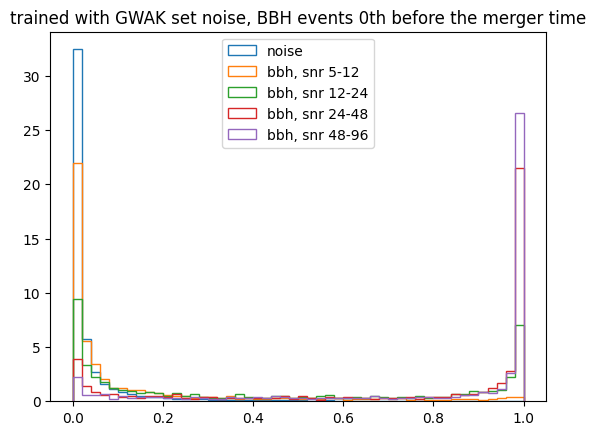

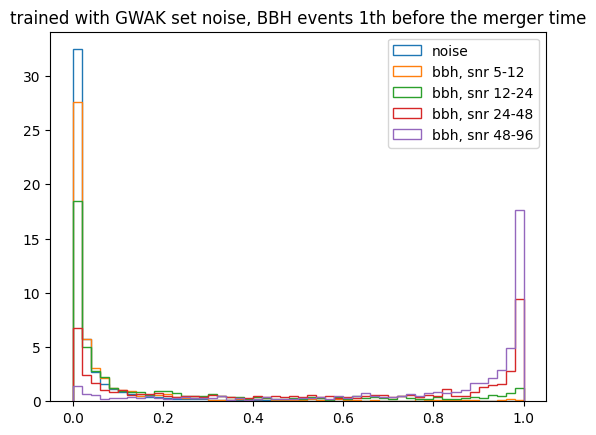

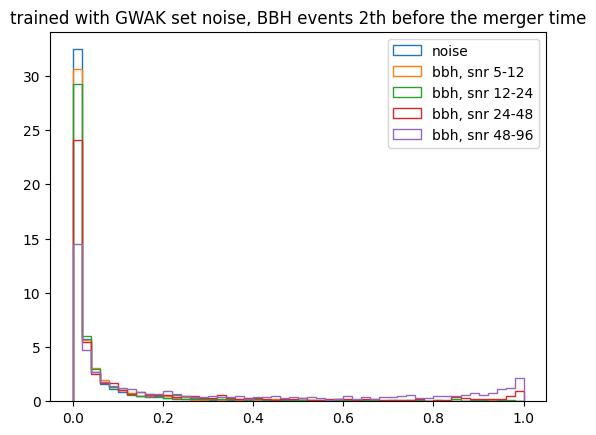

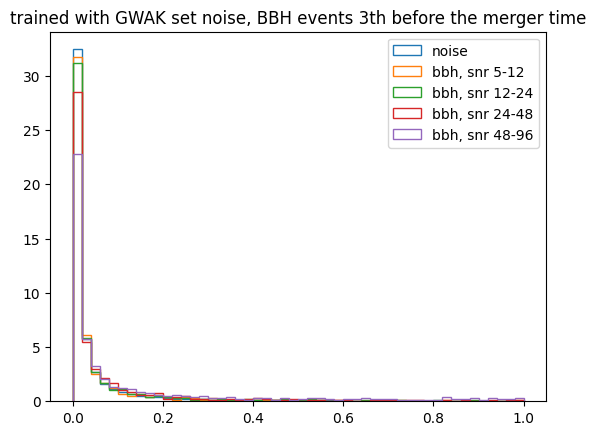

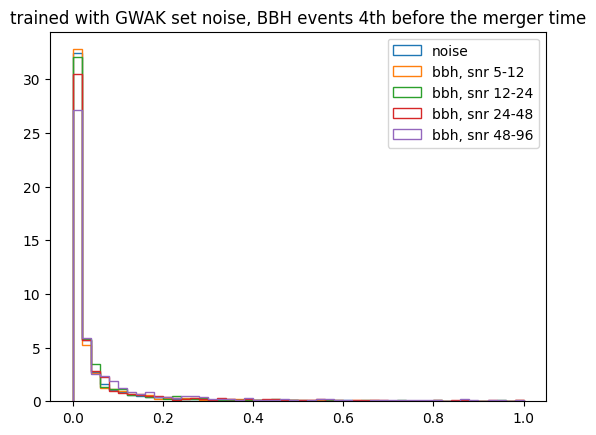

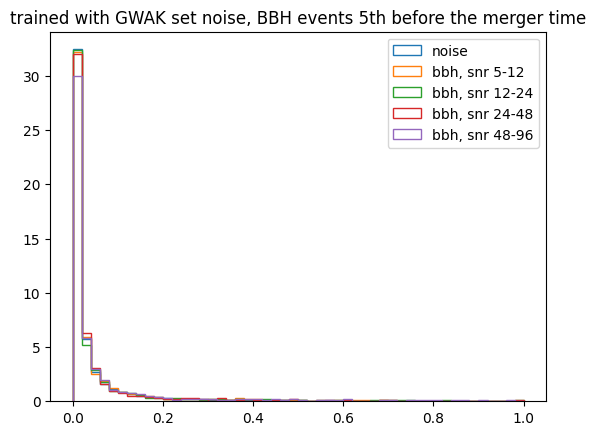

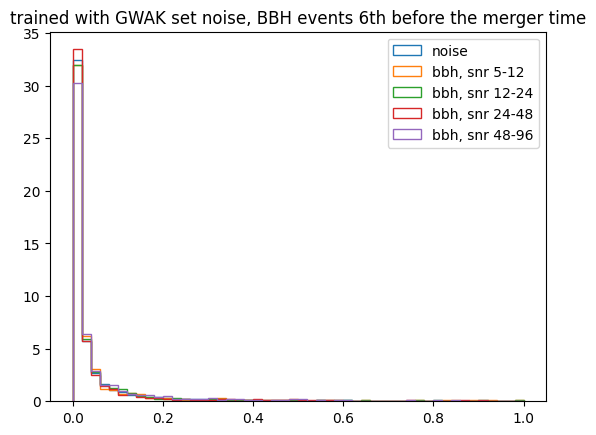

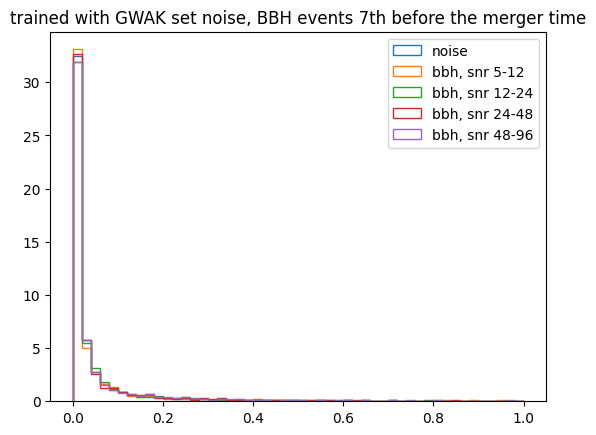

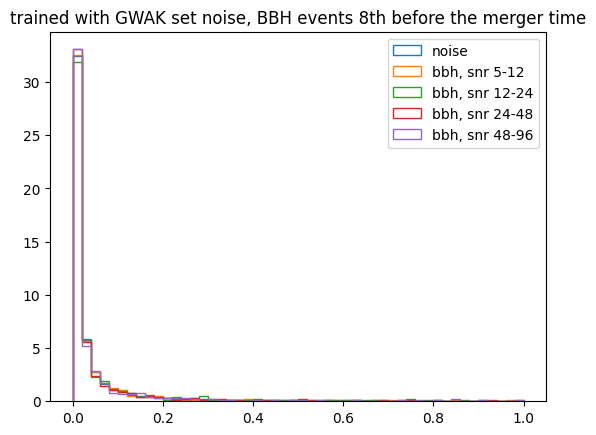

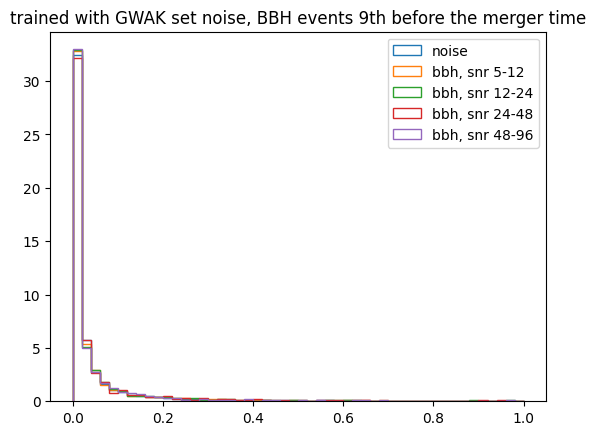

In [35]:
idx_list = np.arange(10)
snr_list = ['5-12','12-24','24-48','48-96']

realbbh_list = {}

for idx in idx_list:
    for snr_range in snr_list:
    
        realbbh_data = np.load('../Data_cached/injected_BBH_snr'+ snr_range +'_' + str(idx) + 'th_events_before_merger_time.npz')['strain'].reshape(-1,200)
        realbbh_data = (realbbh_data - np.transpose([np.mean(realbbh_data, axis=1)]))/np.transpose([np.std(realbbh_data, axis=1)])
        realbbh_data = realbbh_data.reshape(-1,400)
        
        realbbh_list[snr_range] = realbbh_data.reshape(-1,2,200)

    bkg_reserved = bkg_reserved.reshape(-1,2,200)

    dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_reserved[:,[0],:]))).detach().numpy()
    # dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
    # dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
    # dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in realbbh_list.keys():
        dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(realbbh_list[snr][:,[0],:]))).detach().numpy()
        foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh, snr " + snr)

    plt.title("trained with GWAK set noise, BBH events {}th before the merger time".format(idx))
    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    # plt.ylim(0,2000)
    plt.legend()
    plt.show()

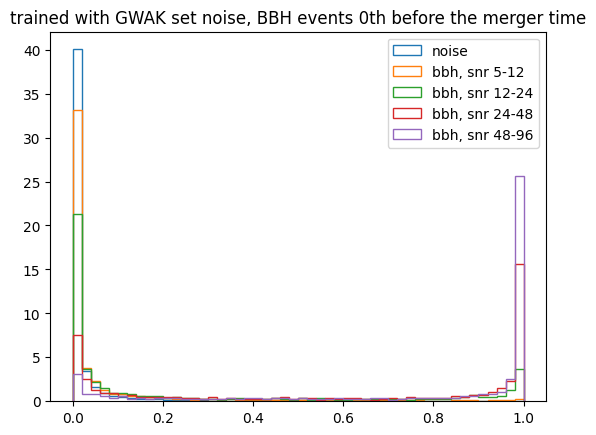

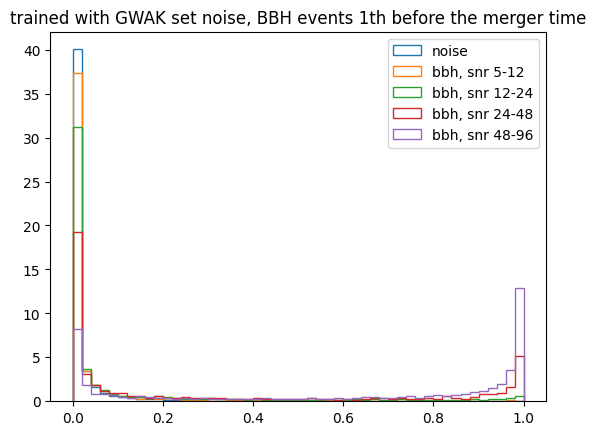

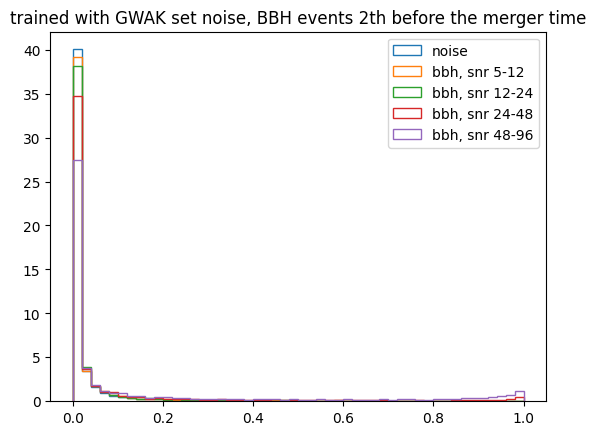

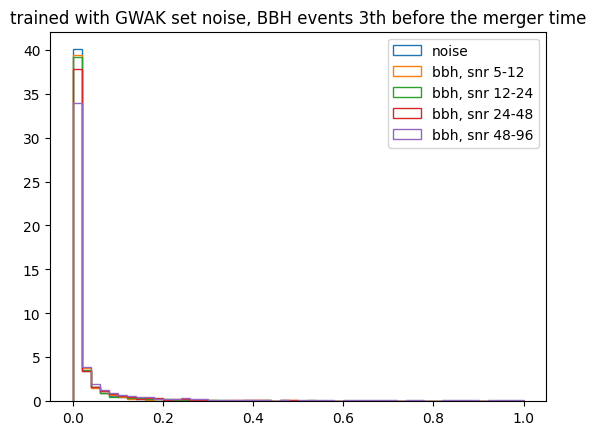

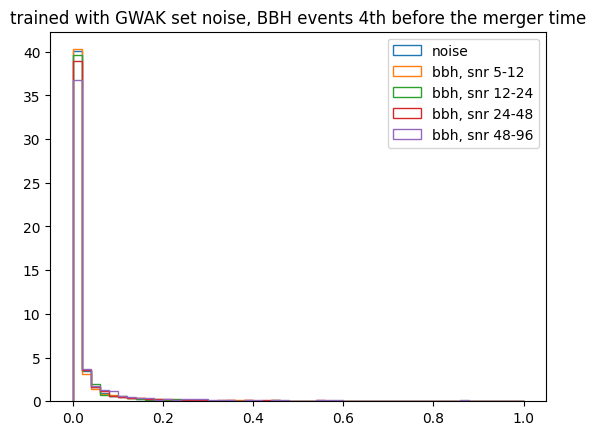

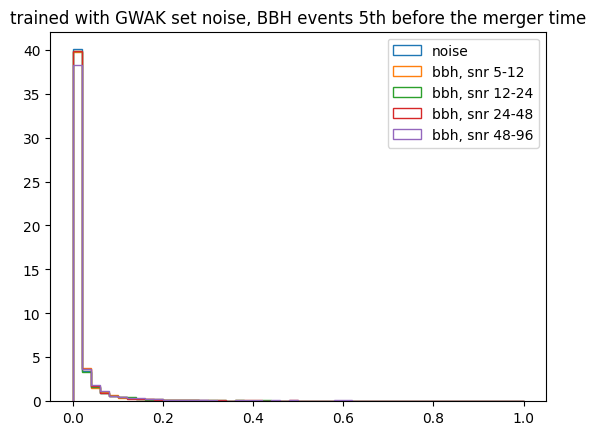

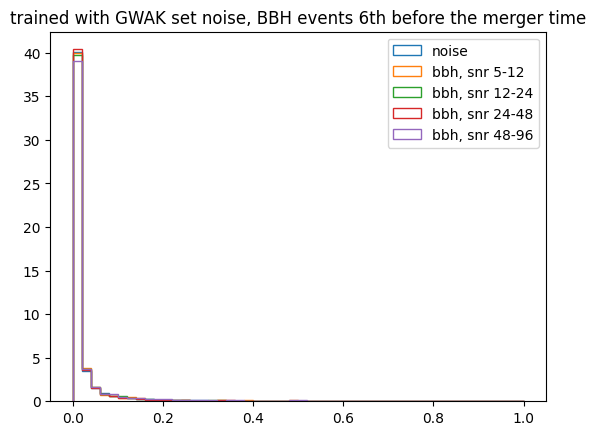

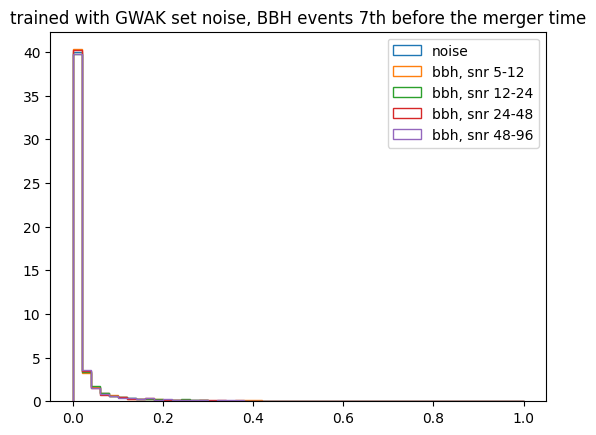

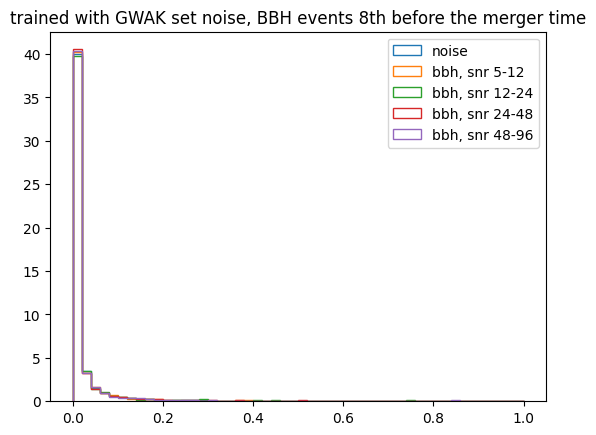

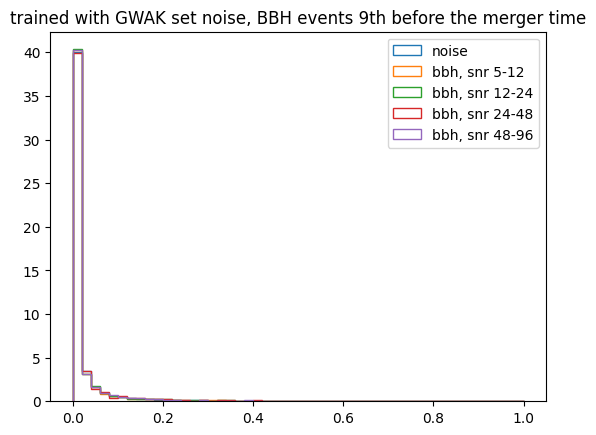

In [27]:
idx_list = np.arange(10)
snr_list = ['5-12','12-24','24-48','48-96']

realbbh_list = {}

for idx in idx_list:
    for snr_range in snr_list:
    
        realbbh_data = np.load('../Data_cached/injected_BBH_snr'+ snr_range +'_' + str(idx) + 'th_events_before_merger_time.npz')['strain'].reshape(-1,200)
        realbbh_data = (realbbh_data - np.transpose([np.mean(realbbh_data, axis=1)]))/np.transpose([np.std(realbbh_data, axis=1)])
        realbbh_data = realbbh_data.reshape(-1,400)
        
        realbbh_list[snr_range] = realbbh_data.reshape(-1,2,200)

    bkg_reserved = bkg_reserved.reshape(-1,2,200)

    dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_reserved[:,0,:]))).detach().numpy()
    # dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
    # dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
    # dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

    foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
    # foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
    # foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")

    for snr in realbbh_list.keys():
        dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(realbbh_list[snr][:,0,:]))).detach().numpy()
        foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh, snr " + snr)

    plt.title("trained with GWAK set noise, BBH events {}th before the merger time".format(idx))
    # plt.axvline(c0[currentStep], color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    # plt.ylim(0,2000)
    plt.legend()
    plt.show()